# Homework 3: preconditioning techniques

15 points

## Full credit: due November 3, before class

## 80% credit: due December 1

**collaboration statement:**

In [1]:
%pip install numpy scipy matplotlib
import numpy as np
from scipy.sparse import tril, triu, diags, rand, eye, csr_matrix, kron, dia_matrix, lil_matrix
from scipy.sparse.linalg import cg, spsolve, spsolve_triangular, LinearOperator
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


**Question 1 (2 points):** _(after lecture 3.1)_ The convergence bound for the error $x^\star - x_m$ that was developed for the unpreconditioned conjugate gradient method was

$$\| x^\star - x_m \|_A \leq 2 \left(\frac{\sqrt{\kappa_2(A)} - 1}{\sqrt{\kappa_2(A)} + 1}\right)^m \| x^\star - x_0 \|_A.$$

Adapt this to get an error bound for CG preconditioned by $M^{-1}$.

_Hint:_ You can't just substitute $M^{-1}A$ for $A$.  To get the correct inequality, you can start with the bound for the split-preconditioned system, which will be phrased in terms of an ansatz error $u^\star - u_m$.

Let $M = L L^T$: the symmetric preconditioned system of equations is

$$\begin{aligned}L^{-1} A L^{-T} u^\star &= L^{-1} b \\
x^\star &= L^{-T} u^\star.
\end{aligned}$$

We can use the convergence bound above directly on $u^\star - u_m$,

$$\| u^\star - u_m \|_{L^{-1}AL^{-T}} \leq 2 \left(\frac{\sqrt{\kappa_2(L^{-1}AL^{-T})} - 1}{\sqrt{\kappa_2(L^{-1}AL^{-T})} + 1}\right)^m \| u^\star - u_0 \|_{L^{-1}AL^{-T}}.$$

We can then substitute $u^\star = L^T x^\star$ and $u_m = L^T x_m$:

$$\| L^T(x^\star - x_m) \|_{L^{-1}AL^{-T}} \leq 2 \left(\frac{\sqrt{\kappa_2(L^{-1}AL^{-T})} - 1}{\sqrt{\kappa_2(L^{-1}AL^{-T})} + 1}\right)^m \| L^T(x^\star - x_0) \|_{L^{-1}AL^{-T}}.$$

We can use this fact:

$$\| L^T y \|^2_{L^{-1}AL^{-T}} = (L^T y, L^{-1} A L^{-T} L^T y) = (L^{-T} L^T y, A L^{-T} L^T y) = (y, A y) = \|y\|^2_A,$$

to get the bound

$$\|x^\star - x_m \|_{A} \leq 2 \left(\frac{\sqrt{\kappa_2(L^{-1}AL^{-T})} - 1}{\sqrt{\kappa_2(L^{-1}AL^{-T})} + 1}\right)^m \| x^\star - x_0 \|_{A}.$$

Finally, $\kappa_2(L^{-1} A L^{-T}) = \kappa_2(M^{-1} A)$, so we get

$$\|x^\star - x_m \|_{A} \leq 2 \left(\frac{\sqrt{\kappa_2(M^{-1}A)} - 1}{\sqrt{\kappa_2(M^{-1}A)} + 1}\right)^m \| x^\star - x_0 \|_{A}.$$

So preconditioning improves the bound, but does not change the norm used.

**Question 2 (4 points):** _(after lecture 3.1)_ In module 1 we saw that SOR was particularly effective for finite difference discretizations with the optimal choice of the scaling parameter $\omega$.  But, SOR is not an s.p.d. preconditioner.

Implement _symmetric successive over-relaxation_ (SSOR) below.  Then, for $n = 4, 8, 16, 32$, choose an $\omega_n$ that appears to give you the best convergence rate for the 3D finite difference Laplacian in the graph below.

_Hint:_ In Homework 1, question 7, you should have observed for the basic (Richardson) iteration preconditioned by SOR that $$\tau = - \ln \rho \propto n^{-1},$$ which roughly corresponded to the condition number of the preconditioned operator being $$\kappa_{SOR} \propto n.$$ Assuming $\kappa_{SSOR} \approx \kappa_{SOR}$ Plugging this in to the asymptotic bound for CG, we expect
$$-\ln \rho = -\ln \tfrac{\sqrt{\kappa_{SSOR}} - 1}{\sqrt{\kappa_{SSOR}} + 1} \propto \tfrac{1}{\sqrt{n}}.$$  In other words every time $n$ increases by a factor of 4, the convergence rate should decrease by a factor of $\approx 1/2$.

In [2]:
def ssor(A, r, omega=1.):
    """
    Args:
        A (implements .diagonal(), works with scipy.sparse.tril and scipy.sparse.triu): s.p.d. matrix
        r (ndarray): residual vector
        omega (float): SOR constant
    Returns:
        (ndarray): the symmetric SOR preconditioner applied to the system A x = b.
    """
    ### BEGIN SOLUTION
    D = diags(A.diagonal())
    E = -tril(A,-1)
    return omega * (2. - omega) * spsolve_triangular(D - omega * E.T, D @ spsolve_triangular(D - omega * E, r), lower=False)
    ### END SOLUTION

In [3]:
# Create a random s.p.d. matrix
n = 1000
B = rand(n, n, 0.01)
A = csr_matrix(B.T @ B + eye(n))

# Apply SSOR to two random vectors
r = np.random.randn(n)
q = np.random.randn(n)
Mr = ssor(A, r, omega=1.5)
Mq = ssor(A, q, omega=1.5)

# Tests symmetry
rMq = r.dot(Mq)
qMr = q.dot(Mr)
assert(abs(rMq - qMr) <= 1.e-8 * max(abs(rMq), abs(qMr)))

# Test positive definiteness
assert(r.dot(Mr) > 0.)
assert(q.dot(Mq) > 0.)

### BEGIN HIDDEN TESTS
def _ssor(A, r, omega=1.):
    D = diags(A.diagonal())
    E = -tril(A,-1)
    return omega * (2. - omega) * spsolve_triangular(D - omega * E.T, D @ spsolve_triangular(D - omega * E, r), lower=False)

_Mr = _ssor(A, r, omega=1.5)
assert(np.linalg.norm(Mr - _Mr) < 1.e-8 * np.linalg.norm(_Mr))
### END HIDDEN TESTS

In [4]:
def laplacian(d, n):
    """
    Args:
        d (int): dimension (1, 2, or 3)
        n (int): the number of unknowns per direction
    Returns:
        csr_matrix: the finite difference Laplacian on the unit cube [0,1]^d
        with Dirichlet boundary conditions.  Matrix size is (n^d x n^d)
    """
    h = 1. / (n + 1.)
    L = (1./ h)**2 * dia_matrix((np.array([[-1.],[2.],[-1.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
    I1 = eye(n)
    I2 = eye(n*n)
    if d == 1:
        return csr_matrix(L)
    if d == 2:
        return csr_matrix(kron(L, I1) + kron(I1, L))
    if d == 3:
        return csr_matrix(kron(L, I2) + kron(I1, kron(L, I1)) + kron(I2, L))

average convergence rate, n=4, 2.801579905868565
average convergence rate, n=8, 1.9330881452203574
average convergence rate, n=16, 1.3583598830277348
average convergence rate, n=32, 0.944199609554698


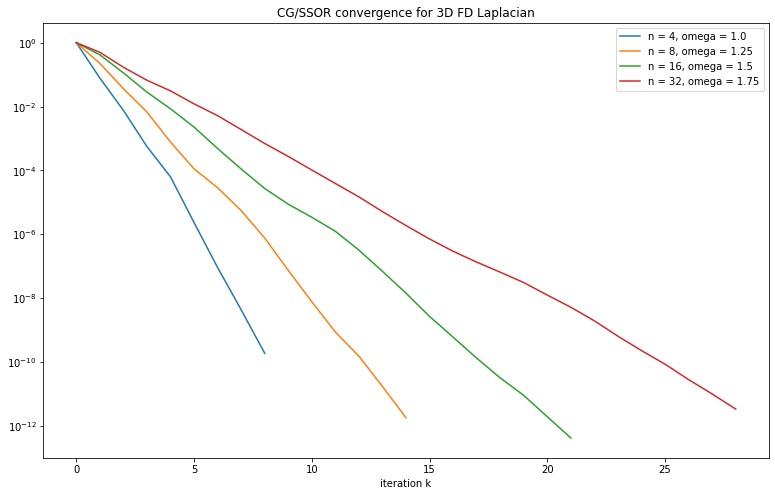

In [5]:
d = 3
ax = plt.figure(figsize=(13,8)).gca()
ax.set(title="CG/SSOR convergence for 3D FD Laplacian", xlabel="iteration k")
ns = [4, 8, 16, 32]
omegas = [1., 1., 1., 1.]
# Modify omegas here
### BEGIN SOLUTION
def omega_opt(n):
    rho_jacobi = np.cos(np.pi/(n+1))
    o_opt = 2. / (1. + (1. - rho_jacobi**2)**0.5)
    return o_opt
omegas = [1.0, 1.25, 1.5, 1.75]
### END SOLUTION
for n, omega in zip(ns, omegas):
    K = laplacian(d, n)
    b = np.ones(K.shape[0]) + np.random.randn(K.shape[0])
    b = np.ones(K.shape[0])
    M = LinearOperator(shape = K.shape, matvec = lambda r: ssor(K, r, omega), dtype=K.dtype)
    xks = []
    def append_sol(xk):
        xks.append(xk.copy())
    xsol, info = cg(K, b, x0 = np.zeros(n**d), M=M, atol=0., tol=1.e-12, maxiter = 30, callback=append_sol)
    xtrue = xsol
    errors = np.array([(x - xtrue).dot(K @ (x - xtrue))**0.5 for x in xks])
    factor = np.exp(np.log(errors[-2] / errors[0]) / (len(errors) - 2))
    print("average convergence rate, n={},".format(n), -np.log(factor))
    plt.semilogy(errors[:-1] / errors[0], label="n = {}, omega = {}".format(n, omega))
_ = ax.legend()

In [6]:
# Your omegas should all be valid
omegas = np.array(omegas)
assert(np.all(0. < omegas) and np.all(omegas < 2.))

### BEGIN HIDDEN TESTS
omega_range = np.array([[0.8,1.2],[1.05,1.45],[1.3,1.7],[1.55,1.95]])
assert(np.all(omega_range[:,0] < omegas) and np.all(omegas < omega_range[:,1]))
### END HIDDEN TESTS

**Question 3 (2 points):** _(after lecture 3.2)_ Let $L_0, U_0$ be the ILU(0) incomplete factors of a 3D 7-point stencil matrix.  For such a stencil matrix, an incomplete factorization has a compressed representation, where there is a diagonal matrix $\tilde{D}$ such that $$L_0 U_0 = (\tilde{D} - E) \tilde{D}^{-1} (\tilde{D} - F).$$

Compute $\tilde{D}$.

_Hint:_ In an ILU(0), $(L_0 U_0)_{i,j} = A_{i,j}$ if $(i,j)$ is in the sparsity pattern of $A$.  That must mean that $\text{diag}((\tilde{D} - E) \tilde{D}^{-1} (\tilde{D} - F)) = \text{diag}(A)$.

$$(\tilde{D} - E) \tilde{D}^{-1} (\tilde{D} - F) = (I - E \tilde{D}^{-1}) (\tilde{D} - F) = \tilde{D} - E - F + E\tilde{D}^{-1}F$$

$$\text{diag}(\tilde{D} - E) \tilde{D}^{-1} (\tilde{D} - F) = 
\tilde{D} + \text{diag}(E \tilde{D}^{-1} F) = \text{diag}(A)$$

So $\tilde{D} = \text{diag}(A) - \text{diag}(E \tilde{D}^{-1} F)$.  Use this fact to recursively compute $\tilde{D}$.

In [7]:
def ilu0(A):
    """ILU(0) factorization of a CSR matrix"""
    n = A.shape[0]
    LU = csr_matrix(A.copy())
    for i in range(n):
        for l in range(A.indptr[i], A.indptr[i+1]):
            k = A.indices[l]
            if k >= i:
                break
            LU[i,k] /= LU[k,k]
            for m in range(l + 1, A.indptr[i+1]):
                j = A.indices[m]
                LU[i,j] -= LU[i,k] * LU[k,j]
    return LU

def apply_ilu0(ILU0, b):
    """Apply the incomplete factorization to a right hand side"""
    n = ILU0.shape[0]
    L = csr_matrix(tril(ILU0, -1) + eye(n))
    U = csr_matrix(triu(ILU0))
    u = spsolve_triangular(L, b)
    x = spsolve_triangular(U, u, lower=False)
    return x

In [8]:
def stencil_ilu0_diagonal(A):
    """
    Args:
        A (csr_matrix(n,n)): system matrix for a stencil operation
    Returns:
        Dtilde (ndarray(n)): the diagonal vector such that (Dtilde - E) Dtilde^{-1} (Dtilde - F) is equivalent
        to the ILU(0) incomplete factorization of A
    """
    ### BEGIN SOLUTION
    D0 = A.diagonal()
    Dtilde = D0.copy()
    n = A.shape[0]
    E = csr_matrix(-tril(A,-1))
    F = csr_matrix(-triu(A,1))
    for i in range(1,n):
        Dtilde[i] = D0[i] - (E[i,:i] @ (diags(1./Dtilde[:i]) @ F[:i,i]))[0,0]
    return Dtilde
    ### END SOLUTION

In [9]:
def apply_stencil_ilu0(A, Dtilde, b):
    E = csr_matrix(-tril(A,-1))
    F = csr_matrix(-triu(A,1))
    L = csr_matrix(diags(Dtilde) - E)
    U = csr_matrix(diags(Dtilde) - F)
    u = spsolve_triangular(L, b)
    v = diags(Dtilde) @ u
    x = spsolve_triangular(U, v, lower=False)
    return x

In [10]:
n = 10
d = 3
K = csr_matrix(laplacian(d, n))
K.eliminate_zeros()
b = np.random.randn(n**d)
ILU0 = ilu0(K)
x = apply_ilu0(ILU0, b)
Dtilde = stencil_ilu0_diagonal(K)
xtilde = apply_stencil_ilu0(K, Dtilde, b)
assert(np.linalg.norm(xtilde - x) < 1.e-8)

**Question 4 (3 points):** _(after lecture 3.3)_ Saad remarks that for smoothers for multigrid, "SOR $(\omega \neq 1)$ is rarely used as it is known that overrelaxation provides no benefit."  Here you will verify this fact.

Given a fine matrix $A_h$, a coarse matrix $A_H$, restriction $R$ and prolongation operators $P$, you will construct the iteration matrix $G$ for the two-grid multigrid preconditioner (Saad algorithm 13.2), where the pre- and post-smoothers are each one application of SOR($\omega$).  The spectral radius of your matrix will be computed and plotted for multiple values of $\omega$ when $A_h$ is the 1D FD Laplacian.  Unlike when SOR is used as a solver instead of a smoother, we should see little to no advantage for using an $\omega \neq 1$.

In [16]:
def sor_two_grid(A_h, A_H, P, R, omega):
    """
    Args:
        A_h (ndarray): matrix for the fine grid
        A_H (ndarray): matrix for the coarse grid
        P (ndarray): matrix for the prolongation operator
        R (ndarray): matrix for the restriction operator
        omega (float): the sor coefficient to use
    Returns:
        G (ndarray): dense representation of the iteration matrix for one application of the two grid
        solver (Saad algorithm 13.2), smoothed once by SOR(omega) before and after the coarse grid correction
    """
    ### BEGIN SOLUTION
    D = diags(A_h.diagonal()).toarray()
    E = -tril(A_h, -1)
    M = (1. / omega) * D - E
    Minv = np.linalg.inv(M)
    I_h = np.eye(A_h.shape[0])
    Gpre = I_h - Minv @ A_h
    RG = R @ Gpre
    XH = np.linalg.solve(A_H, RG)
    PXH = P @ XH
    Xh = Minv + PXH
    Gpost = (I_h - Xh @ A_h)
    Dh = Minv @ Gpost
    Gfinal = I_h - (Xh + Dh) @ A_h
    return Gfinal
    ### END SOLUTION

In [17]:
n_H = 50
n_h = n_H * 2 + 1
P = lil_matrix((n_h, n_H))
for i in range(n_H):
    P[2*i, i] = 0.5
    P[2*i + 1, i] = 1.0
    P[2*i + 2, i] = 0.5
P = P.toarray()
R = P.T / 2.
A_H = laplacian(1, n_H).toarray()
A_h = laplacian(1, n_h).toarray()
G_twogrid = sor_two_grid(A_h, A_H, P, R, 1.3)
rho_twogrid = np.max(np.abs(np.linalg.eigvals(G_twogrid)))
assert(rho_twogrid < 1.)
### BEGIN HIDDEN TESTS
def _sor_two_grid(A_h, A_H, P, R, omega):
    D = diags(A_h.diagonal()).toarray()
    E = -tril(A_h, -1)
    M = (1. / omega) * D - E
    Minv = np.linalg.inv(M)
    I_h = np.eye(A_h.shape[0])
    Gpre = I_h - A_h @ Minv
    RG = R @ Gpre
    XH = np.linalg.solve(A_H, RG)
    PXH = P @ XH
    Xh = Minv + PXH
    Gpost = (I_h - A_h @ Xh)
    Dh = Minv @ Gpost
    Gfinal = I_h - A_h @ (Xh + Dh)
    return Gfinal
_G_twogrid = _sor_two_grid(A_h, A_H, P, R, 1.3)
assert(np.linalg.norm(_G_twogrid - G_twogrid) < 1.e-8)
### END HIDDEN TESTS

AssertionError: 

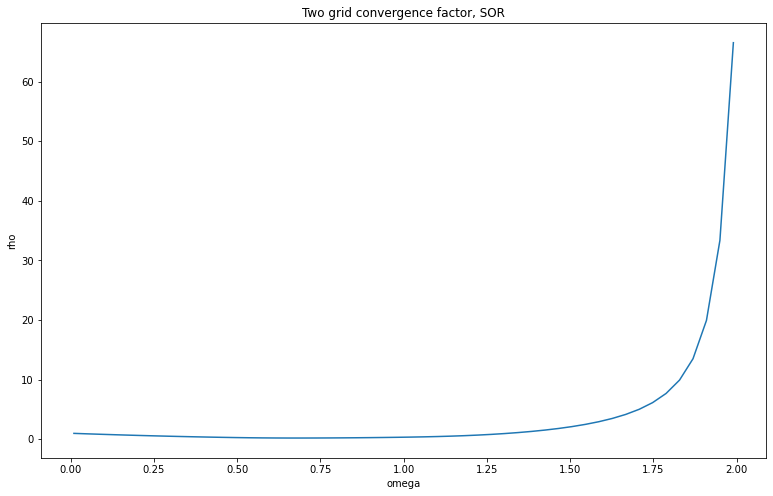

In [18]:
omegas = np.linspace(0.01, 1.99)
rhos = []
for omega in omegas:
    G_twogrid = sor_two_grid(A_h, A_H, P, R, omega)
    rho_twogrid = np.max(np.abs(np.linalg.eigvals(G_twogrid)))
    rhos.append(rho_twogrid)
ax = plt.figure(figsize=(13,8)).gca()
ax.set(title="Two grid convergence factor, SOR")
ax.set(xlabel="omega")
ax.set(ylabel="rho")
_ = ax.plot(omegas, rhos)

In [14]:
def laplacian_2d(n, discretization='FD'):
    h = 1. / (n + 1.)
    L = dia_matrix((np.array([[-1.],[2.],[-1.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
    if discretization == 'FE':
        L /= h
    else:
        L /= h**2
    if discretization == 'FE':
        M = dia_matrix((np.array([[1./6.],[2./3.],[1./6.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
        M *= h
    else:
        M = eye(n)
    return kron(L, M) + kron(M, L)

**Question 5 (4 points):** _(after lecture 3.7)_

A (2 points). Suppose

$$A = \begin{bmatrix} I & U^T \\ U & 0 \end{bmatrix},$$

where $U \in \mathbb{R}^{m \times n}$, $m < n$, and $UU^T = I$. How many eigenvalues does $A$ have and what are they?

_Hint:_ When in doubt, try constructing a matrix like this and see what eigenvalues you see, then prove that those are all the possible eigenvalues.

Because $m < n$, there must be some $x^\star$ in the nullspace of $U$.  Let $v = (x^\star, 0)$: it is clear that $A v = v$, so $\lambda = 1$ is an eigenvalue.

Now let $v = (x, y)$, where $x$ is not in the nullspace of $U$, be a nonzero eigenvector with eigenvalue $\lambda$

Then 

$$\begin{aligned}
x + U^T y &= \lambda x \\
U x &= \lambda y.
\end{aligned}$$

Multiplying the top equation by $U$ and applying $UU^T = I$ gives

$$\begin{aligned}
Ux + y &= \lambda Ux \\
U x &= \lambda y.
\end{aligned}$$

Plugging the second equation into the first equation gives

$$(1 + \lambda) y = \lambda ^2 y,$$

so $\lambda$ must satisfy $\lambda^2 - \lambda - 1 = 0$, so there are two additional eigenvalues, one positive and one negative:

$$\lambda = \frac{1 \pm \sqrt{5}}{2}.$$

The full set of eigenvalues is

$$\{(1 - \sqrt{5})/2, 1, (1 + \sqrt{5})/2\}.$$

B (2 points).  Use your result from A to prove the following. Suppose
$$A = \begin{bmatrix} F & B^T \\ B & 0 \end{bmatrix},$$ where $F$ is s.p.d., $B \in \mathbb{R}^{m \times n}$, $m < n$, and $B^T$ has full column rank.  Let
$$M = \begin{bmatrix} F^{-1} & 0 \\ 0 & (B F^{-1} B^T)^{-1}\end{bmatrix}.$$ $M$ is s.p.d. so it can be used as a preconditioner in MINRES.  In the code below trying this type of preconditioning out on a random matrix, using using MINRES to solve $Ax = b$ preconditioned by $M$ converges in three iterations.  Prove that it will always converge in at most three iterations.

_Hints:_

- Much like CG, $M$-preconditioned MINRES iterations are equivalent to the iterations generated by MINRES applied to the split preconditioned system $L A L^T$ where $M = L^T L$.
- What optimality condition is satisfied after $m$ iterations of a minimum residual method like MINRES?
- The split preconditioned system $L A L^T$ is normal.

In [15]:
from scipy.sparse.linalg import minres

n = 4
m = 2
C = np.random.randn(n,n)
F = C.T @ C
Finv = np.linalg.inv(F)
B = np.random.randn(m, n)
S = B @ Finv @ B.T
Sinv = np.linalg.inv(S)
A = np.zeros((n+m, n+m))
A[:n,:n] = F
A[n:,:n] = B
A[:n,n:] = B.T
M = np.zeros((n+m,n+m))
M[:n,:n] = Finv
M[n:,n:] = Sinv
b = np.random.randn(n+m)
x, info = minres(A,b,x0 = np.zeros((n+m,)), M=M, maxiter=3)
print(np.linalg.norm(A @ x - b))

2.537776533509386e-15


Let $F = L_F L_F^T$ and $S = L_S L_S^T$ if we let

$$L = \begin{bmatrix} L_F^{-1} & 0 \\ 0 & L_S^{-1} \end{bmatrix},$$

Then $M = L^T L$.  The split preconditioned system $L A L^T$ is

$$
L^T A L = \begin{bmatrix} I & L_F^{-1} B^T L_S^{-T} \\ L_S^{-1} B^T L_F^{-T} & 0 \end{bmatrix}.$$

If we let $U = L_S^{-1} B^T L_F^{-T}$, then we have $$U U^T = L_S^{-1} B^T L_F^{-T} L_F^{-1} B^T L_S^{-T}
= L_S^{-1} B^T F^{-1} B L_S^{-T} = L_S^{-1} S L_S^{-T} = I.$$  Therefore $LAL^T$ has two eigenvalues.  It is also normal, so its eigenbasis $V$ is orthonormal.

MINRES after $m$ steps will minimize the symmetric preconditioned residual

$$\|(I - (LAL^T)p(L A L^T))(L b)\|_2$$

over all polynomials $p$ with degree at most $m-1$.  We can use the orthogonal eigenbasis to say that this quantity is equivalent to

$$\|(I - \Lambda p(\Lambda))(V^T L b)\|_2,$$

which means that MINRES minimizes $\|q(\Lambda) (V^T L b)\|_2$ over all polynomials of degree at most $m$ such that $q(0) = 1$.  A scaled version of the characteristic polynomial of $A$ satisfies $q(0) = 1$ and $q(\Lambda) = 0$ if $m = 3$, so the residual will be zero after at most three iterations.